In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle
import statsmodels.stats.power
import statsmodels.api as sm
import statsmodels.stats.multitest as mt
from sklearn import datasets

## Power

In [2]:
mu_0 = 30
mu_a = 32
alpha = 0.05
sigma = 4
n = 16
z = stats.norm.ppf(1 - alpha)
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_0, scale=sigma/np.sqrt(n)))
print(stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n)))

0.049999999999999954
0.6387600313123348


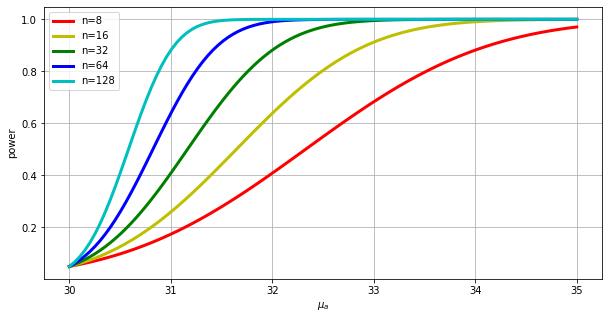

In [3]:
def power(mu_a, n):
    mu_0, alpha, sigma = 30, 0.05, 4
    z = stats.norm.ppf(1 - alpha)
    return stats.norm.sf(mu_0 + z * sigma/np.sqrt(n), loc=mu_a, scale=sigma/np.sqrt(n))

mu_a = np.linspace(30, 35, 100)

plt.figure(figsize=(10,5))
[plt.plot(mu_a, power(mu_a, n), lw=3, color=c) 
     for n,c in [(8, 'r'), (16, 'y'), (32, 'g'), (64, 'b'), (128, 'c')]
]
plt.grid()
plt.legend(['n=8', 'n=16', 'n=32', 'n=64', 'n=128'])
plt.xlabel('$\mu_a$')
plt.ylabel('power')
plt.show()

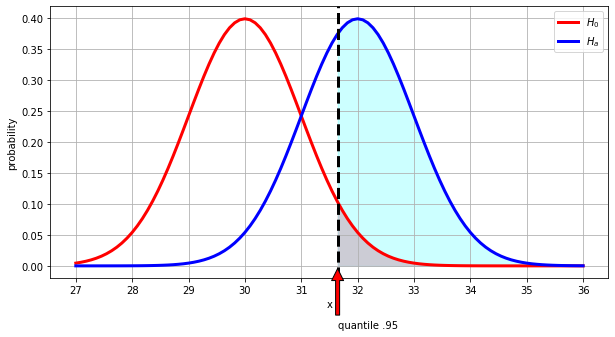

In [4]:
mu_0 = 30
mu_a = 32
sigma = 4
n = 16
alpha = 0.05

x = np.linspace(27, 36, 100)
y_0 = stats.norm.pdf(x, loc=mu_0, scale=sigma/np.sqrt(n))
y_a = stats.norm.pdf(x, loc=mu_a, scale=sigma/np.sqrt(n))
x_black = stats.norm.ppf(0.95, loc=mu_0, scale=sigma/np.sqrt(n))
x1 = np.linspace(x_black, 36, 100)

plt.figure(figsize=(10,5))
plt.plot(x, y_0, lw=3, c='r')
plt.plot(x, y_a, lw=3, c='b')
plt.legend(['$H_0$', '$H_a$'])
plt.grid()
plt.xticks(np.linspace(27, 36, 10))
plt.xlabel('x')
plt.ylabel('probability')
plt.axvline(x=x_black, c='k', linestyle='--', lw=3)
plt.annotate('quantile .95', 
            xy=(x_black, 0), 
            xytext=(x_black, -.1), 
            arrowprops = dict(facecolor='red', shrink=0.05))
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_0, scale=sigma/np.sqrt(n)), color="pink")
plt.fill_between(x1, stats.norm.pdf(x1, loc=mu_a, scale=sigma/np.sqrt(n)), color="cyan", alpha=0.2)
plt.show()

In [5]:
print(stats.norm.sf(x_black, loc=mu_a, scale=sigma/np.sqrt(n)))
print(statsmodels.stats.power.normal_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger')
)

0.6387600313123348
0.638760031312335


In [6]:
print('mu_0: %d, mu_a: %d' % (mu_0, mu_a))
print('sigma: ', sigma)
print('power: ', statsmodels.stats.power.ttest_power(
    effect_size=(mu_a - mu_0)/sigma, 
    nobs=16, alpha=0.05, alternative='larger'))

mu_0: 30, mu_a: 32
sigma:  4
power:  0.6040328683316007


In [7]:
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, nobs=16, alternative='larger'))
print(statsmodels.stats.power.tt_solve_power(
    effect_size=(mu_a - mu_0)/sigma, 
    alpha=0.05, power=0.6040328, alternative='larger'))

0.6040328683316007
15.999997299353062


# Multiple tests

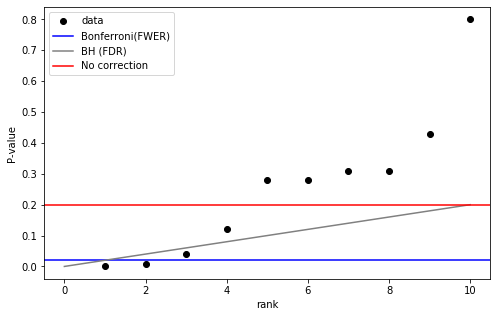

In [8]:
rank = np.array(range(10)) + 1
pValue = np.array([0.001, 0.007, 0.04, 0.12, 0.28, 0.28, 0.31, 0.31, 0.43, 0.8])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(rank, pValue, 'o', c='k')
ax.axhline(y=0.02, c='b')
ax.plot([0, 10], [0., .2], c='gray')
ax.axhline(y=0.2, c='r')
ax.set_xlabel('rank')
ax.set_ylabel('P-value')
ax.legend(['data', 'Bonferroni(FWER)', 'BH (FDR)', 'No correction'])
plt.show()

In [9]:
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction: ', np.sum(pValues < 0.05))

no correction:  39


In [10]:
res = mt.multipletests(pValues, method='bonferroni')
print('Bonferroni correction: ', np.sum(res[1] < 0.05))

res = mt.multipletests(pValues, method='fdr_bh')
print('Benjamini/Hochberg correction: ', np.sum(res[1] < 0.05))

Bonferroni correction:  0
Benjamini/Hochberg correction:  0


In [11]:
# exemplu pentru care coeficientul w al regresiei liniare este:
# 0 pentru primele 500 de situatii construite
# 2 pentru urmatoarele
n = 1000
pValues = np.zeros(n)
for i in range(n):
    x = np.random.randn(20)
    y = np.random.randn(20) if i < n//2 else (np.random.randn(20) + 2*x)
    x = sm.add_constant(x)
    est = sm.OLS(y, x).fit()
    pValues[i] = est.pvalues[1]
    
print('no correction:', np.sum(pValues < 0.05))
res = mt.multipletests(pValues, method='bonferroni')
print('corectie FWER:' , np.sum(res[1] < 0.05))

no correction: 521
corectie FWER: 486


In [12]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValue': pValues
})
pd.crosstab(df.pValue < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValue,,
False,0,479
True,500,21


In [13]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='bonferroni')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,14,500
True,486,0


In [14]:
df = pd.DataFrame({
    'trueStatus': ['zero'] * 500 + ['not zero'] * 500,
    'pValueAdjusted': mt.multipletests(pValues, method='fdr_bh')[1]
})
pd.crosstab(df.pValueAdjusted < 0.05, df.trueStatus)

trueStatus,not zero,zero
pValueAdjusted,,
False,0,489
True,500,11


In [15]:
adjustBonf = mt.multipletests(pValues, method='bonferroni')[1]
adjustBH = mt.multipletests(pValues, method='fdr_bh')[1]

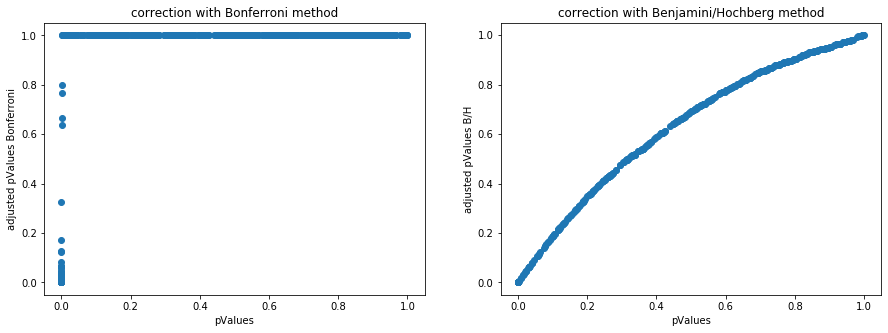

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))
ax1.plot(pValues, adjustBonf, 'o')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.set_title('correction with Bonferroni method')
ax2.plot(pValues, adjustBH, 'o')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues B/H')
ax2.set_title('correction with Benjamini/Hochberg method')
plt.show()

## Bootstrap

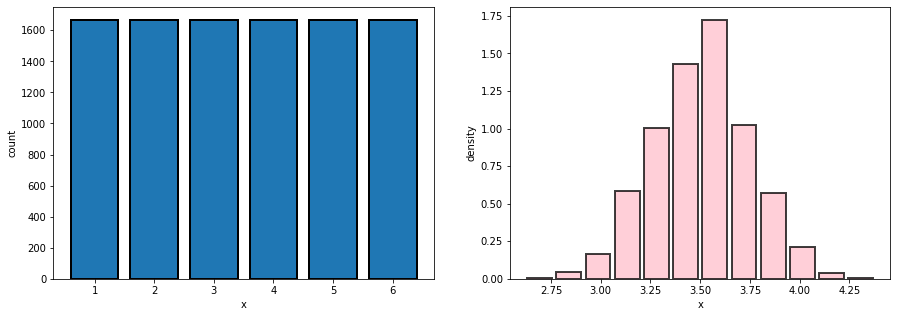

In [17]:
from functools import reduce

def roll(n):
    nosim = 10000
    x = np.random.randint(low=1, high=7, size=(nosim, n))
    return np.mean(x, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

ax1.bar(range(1, 7), [10000/6] * 6, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(50), bins=12, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

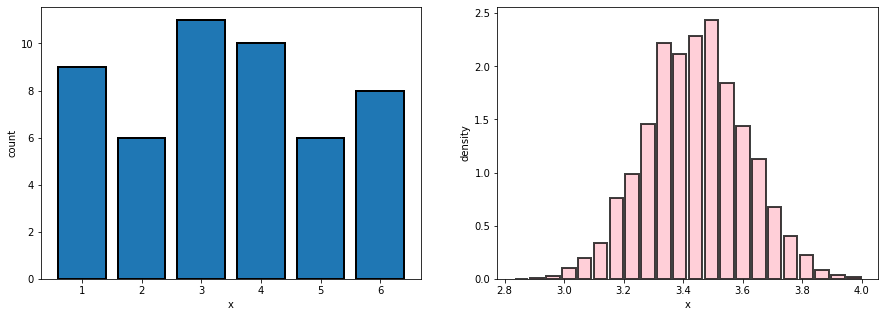

In [18]:
x = np.random.randint(low=1, high=7, size=(50))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)

def roll(x, n):
    nosim = 10000
    x = np.random.choice(x, size=(nosim, n))
    return np.mean(x, axis=1)

l = [sum(np.array(x) == i) for i in range(1, 7)]

ax1.bar(range(1, 7), l, linewidth=2, edgecolor='k')
ax1.set_xlabel('x')
ax1.set_ylabel('count')
ax2.hist(roll(x, 100), bins=22, color='pink', **kwargs)
ax2.set_xlabel('x')
ax2.set_ylabel('density')
plt.show()

In [19]:
father_son = pd.read_csv('father_son.csv')
father_son.head()

,Unnamed: 0,fheight,sheight
0,1,65.04851,59.77827
1,2,63.25094,63.21404
2,3,64.95532,63.34242
3,4,65.75250,62.79238
4,5,61.13723,64.28113


deviatia standard:  0.10390669357018775
quantila 2.5%: 67.552325
quantila 97.5%: 67.94355


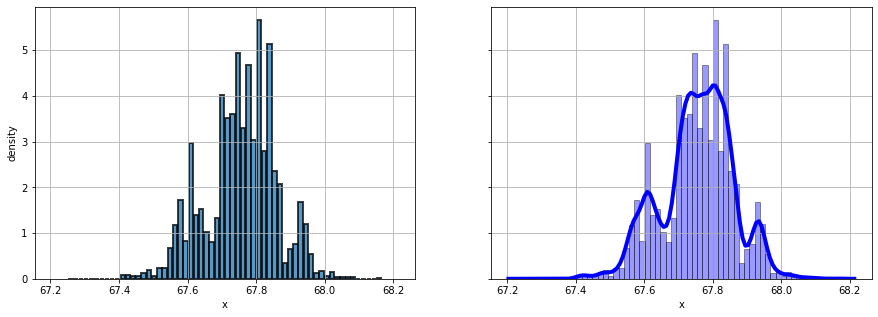

In [20]:
import seaborn

# vezi https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0

x = father_son.fheight.values
n, nosims = len(x), 10000
resamples = np.random.choice(x, size=(nosims, n), replace=True)
resampledMedians = np.median(resamples, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
kwargs = dict(rwidth=0.85, density=True, alpha=0.75, ec='k', linewidth=2)
ax1.hist(resampledMedians, **kwargs, bins=60)
ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('density')
seaborn.distplot(resampledMedians, hist=True, kde=True, bins=60, ax=ax2,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax2.grid()
ax2.set_xlabel('x')

print('deviatia standard: ', np.std(resampledMedians))
print('quantila 2.5%:', np.quantile(resampledMedians, 0.025))
print('quantila 97.5%:', np.quantile(resampledMedians, 0.975))
plt.show()


In [21]:
insect_sprays = pd.read_csv('insect_sprays.csv')
insect_sprays.head()

,Unnamed: 0,count,spray
0,1,10,A
1,2,7,A
2,3,20,A
3,4,14,A
4,5,14,A


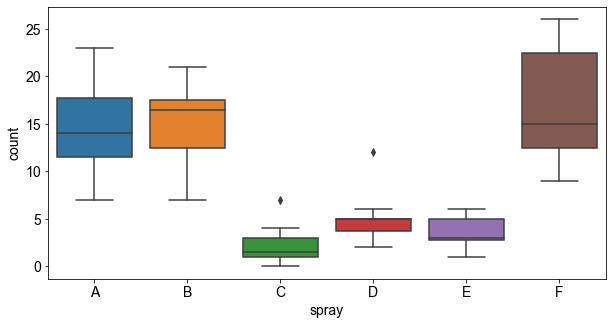

In [22]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.set_style('whitegrid')
seaborn.boxplot(x='spray', y='count', data=insect_sprays, ax=ax)
plt.show()

In [23]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) \
        - np.mean([y for (x, y) in zip(a, b) if x == groups[1]])
    
groups = ['B', 'C']
subdata = insect_sprays[insect_sprays.spray.isin(groups)]

observedStat = testStat(subdata['spray'], subdata['count'], groups)

n = subdata['spray'].values.shape[0]
nosims = 10000
permutations = np.array(list(map(
    lambda x: testStat(x, subdata['count'], groups),
    [np.random.choice(subdata['spray'].values, n) for i in range(nosims)]
)))

print(observedStat)
pValue = np.mean(permutations > observedStat)
print(pValue)

13.25
0.0


deviatia standard:  3.1180431439996203
quantila 2.5%: -5.986246253746252
quantila 97.5%: 6.125763888888878


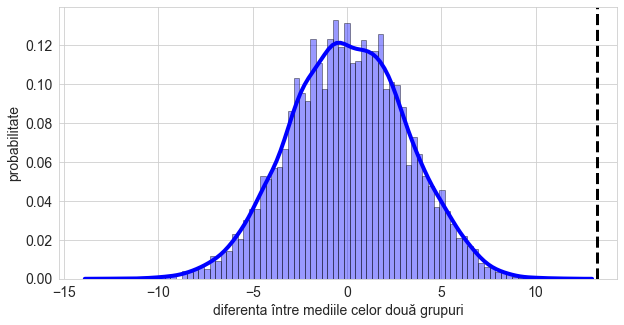

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax,
    color = 'blue',  hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax.grid(True)
ax.set_xlabel('diferenta între mediile celor două grupuri')
ax.set_ylabel('probabilitate')
ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

print('deviatia standard: ', np.std(permutations))
print('quantila 2.5%:', np.quantile(permutations, 0.025))
print('quantila 97.5%:', np.quantile(permutations, 0.975))
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import binom
import pandas as pd
import math
import pickle
import statsmodels.stats.power
import statsmodels.api as sm
import statsmodels.stats.multitest as mt
from sklearn import datasets

## Laborator: exerciţii şi probleme

__Q1__. Power este o probabilitate pentru care se presupune că este adevărată:

1. ipoteza nulă $H_0$
2. ipoteza alternativă $H_a$
3. ambele

In [26]:
print(f"R Q1. 2. ipoteza alternativă")

R Q1. 2. ipoteza alternativă


__Q2__. Pe măsură ce dimensiunea sample-ului crește, restul menținîndu-se constant, ce se întâmplă cu power?

1. se mărește
2. se micșorează
3. rămâne la fel
4. nu putem preciza

In [27]:
print("R Q2. 1. se mărește")

R Q2. 1. se mărește


__Q3__. Ce se întâmplă cu power pe măsură ce $\mu_a$ se îndepărtează față de $\mu_0$ ?

In [28]:
print("R Q3. Power crește pe măsură ce media ipotezei alternative se îndepărtează de media ipotezei alternative.")

R Q3. Power crește pe măsură ce media ipotezei alternative se îndepărtează de media ipotezei alternative.


__Q4__. În contextul calculului power, ce este 'effect size'?

In [29]:
print("R Q4. 'Effect size' reprezintă diferența între medii în unități de deviație standard.")

R Q4. 'Effect size' reprezintă diferența între medii în unități de deviație standard.


__Q5__. Presupunem că în cazul unei testări A/B, o schemă de publicitate a determinat o medie de 10 achiziții pe zi pentru un sample de 100 de zile, în timp ce pentru cealaltă a determinat o medie de 11 achiziții pe zi, pentru același interval de 100 de zile. Presupunem o deviație standard de 4 achiziții pe zi pentru ambele distribuții. 

Media de 10 achiziții/zi este $\mu_0$ asociată ipotezei nule, iar pentru ipoteza alternativă $\mu_a = 11$. Care ar fi power pentru un test Z one-sided cu confidența de 95% ($\alpha=5\%$), în care presupunem că media achizițiilor a crescut la ipoteza alternativă?

In [30]:
mu_0 = 10
mu_a = 11
sigma = 4
alpha = 0.05
n = 100
z = stats.norm.ppf(1 - alpha)
n_sqrt = np.sqrt(n)

ip_0 = stats.norm.sf(mu_0 + z * sigma/n_sqrt, loc=mu_0, scale=sigma/n_sqrt)
ip_a = stats.norm.sf(mu_0 + z * sigma/n_sqrt, loc=mu_a, scale=sigma/n_sqrt)

print(f'R Q5. power pentru ipoteza nulă:\t{ip_0}')
print(f'R Q5. power pentru ipoteza alternativă:\t{ip_a}')

R Q5. power pentru ipoteza nulă:	0.050000000000000024
R Q5. power pentru ipoteza alternativă:	0.8037649400154938


__Q5__. Se dorește crearea unui studiu pentru detectarea valorii medii pe 4 ani a pierderii de volum a creierului, pierdere medie de 0.01 $mm^3$. Presupunem că deviația standard pe media acestor 4 ani este de 0.04 $mm^3$. Care este numărul de voluntari pe care trebuie să se facă studiul pentru un test 5% vs. ipoteza nulă că nu se pierde deloc volum, pentru a atinge power de 80% ?

In [31]:
mu = 0.01 #(0.01 - 0)
sigma = 0.04
alpha = 0.05
power = 0.8

n = statsmodels.stats.power.tt_solve_power(effect_size=mu/sigma,
                                           power=power, alpha=alpha,
                                           alternative='larger')
print(n)
print(f'R Q5. este nevoie de {int(n)} voluntari.')

100.2876635477728
R Q5. este nevoie de 100 voluntari.


__Q6__. Un studiu a observat asocierea mai multor factor nutriționali cu cancerul mamar (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4166692/). Au fost calculate următoarele p-values:

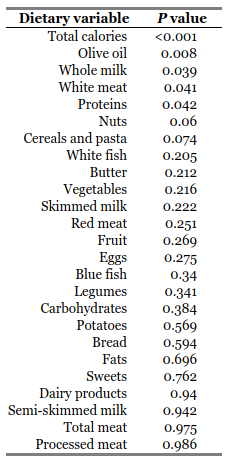

Considerăm un test cu 95% confidență.

a) Fără corecție, care factori sunt relevanți statistic ?

b) Aplicați corecția Bonferroni pe aceste p-values. Care din factori este statistic semnificativ?

c) Aplicați corecția Benjamini/Hochberg. Care factori sunt relevanți statistic în acest caz?

Reprezentați grafic p-values cu corecția Bonferroni vs. p-values fără corecție, respectiv p-values cu corecția Benjamini/Hochberg vs. p-values fără corecție. Puneți pe ambele grafice și pragul de 0.05 ca să vedem ce rejectăm și ce nu.

In [32]:
dietary = np.array(['Olive oil', 'Whole milk', 'White meat',
                    'Proteins', 'Nuts', 'Cereals and pasta', 'White fish',
                    'Butter', 'Vegetables', 'Skimmed milk', 'Red meat', 'Fruit',
                    'Eggs', 'Blue fish', 'Legumes', 'Carbs', 'Potatoes', 'Bread',
                    'Fats', 'Sweets', 'Dairy', 'Semi-skimmed milk', 'Total meat',
                    'Processed meat'])

pValues = np.array([0.008, 0.039, 0.041, 0.042, 0.06, 0.074, 0.205,
                    0.212, 0.216, 0.222, 0.251, 0.269, 0.275, 0.34, 0.341,
                    0.384, 0.569, 0.594, 0.696, 0.762, 0.94, 0.942, 0.975,
                    0.986])
prag = 0.05

In [33]:
diet_a = dietary[pValues < prag]
print(diet_a)

bonf = mt.multipletests(pValues, method='bonferroni')
diet_b = dietary[bonf[1] < prag]
print(diet_b)

hoch = mt.multipletests(pValues, method='fdr_bh')
diet_c = dietary[hoch[1] < prag]
print(diet_c)

['Olive oil' 'Whole milk' 'White meat' 'Proteins']
[]
[]


In [34]:
a = np.sum(pValues < prag)
print(a)
b = np.sum(bonf[1] < prag)
c = np.sum(hoch[1] < prag)

4


In [35]:
print(f'R Q6. a) factorii relevanti statistic sunt:')
for f in diet_a:
    print(f, end=" ")
print()
print()
print(f'R Q6. b) corecția Bonferroni: {b}')
print(f'R Q6. b) niciun factor nu este relevant statistic')
print()
print(f'R Q6. c) corecția Benjamini/Hoghberg: {c}')
print(f'R Q6. c) niciun factor nu este relevant statistic')

R Q6. a) factorii relevanti statistic sunt:
Olive oil Whole milk White meat Proteins 

R Q6. b) corecția Bonferroni: 0
R Q6. b) niciun factor nu este relevant statistic

R Q6. c) corecția Benjamini/Hoghberg: 0
R Q6. c) niciun factor nu este relevant statistic


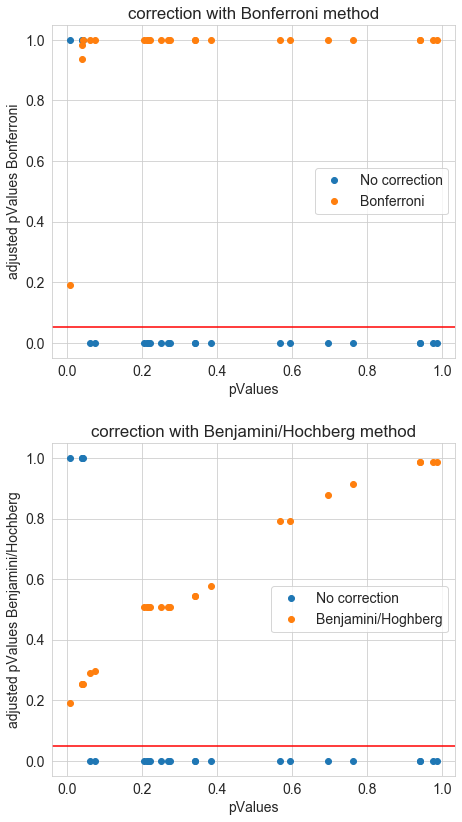

In [36]:
fig, (ax1, ax2) = plt.subplots(2, sharey=False, figsize=(7, 12))

ax1.plot(pValues, pValues < prag, 'o')
ax1.plot(pValues, bonf[1], 'o')
ax1.set_xlabel('pValues')
ax1.set_ylabel('adjusted pValues Bonferroni')
ax1.set_title('correction with Bonferroni method')
ax1.legend(['No correction', 'Bonferroni'])
ax1.axhline(y=0.05, c='r')

ax2.plot(pValues, pValues < prag, 'o')
ax2.plot(pValues, hoch[1], 'o')
ax2.set_xlabel('pValues')
ax2.set_ylabel('adjusted pValues Benjamini/Hochberg')
ax2.set_title('correction with Benjamini/Hochberg method')
ax2.legend(['No correction', 'Benjamini/Hoghberg'])
ax2.axhline(y=0.05, c='r')

fig.tight_layout(pad=2.0)
plt.show()

__Q7__. Ce folosește procedura bootstrap pentru a estima distribuția sampled a unei statistici ?

In [37]:
print(f'R Q7. Procedura bootstrap folosește distribuția definită de date pentru a estima distribuția sampled a unei statistici prin realizarea de extrageri cu înlocuire din datele sample-ului.')

R Q7. Procedura bootstrap folosește distribuția definită de date pentru a estima distribuția sampled a unei statistici prin realizarea de extrageri cu înlocuire din datele sample-ului.


__Q8__. Ce fac testele de resampling? Care este ipoteza nulă și care este ipoteza alternativă? Care este p-value?

In [38]:
print(f'R Q8. Testele de resampling sunt folosite pentru a determina distribuția populației prin determinarea distribuțiilor medii ale populației.')
print(f'R Q8. Ipoteza nulă presupune că distribuțiile medii din testele de resampling sunt aceleași cu distribuțiile medii a populației.')
print(f'R Q8. Ipoteza alternativă presupune că există diferențe între ele.')
print(f'R Q8. P-value reprezintă probabilitatea ca evenimentul pe care l-am observat să fie likely/unlikely.')

R Q8. Testele de resampling sunt folosite pentru a determina distribuția populației prin determinarea distribuțiilor medii ale populației.
R Q8. Ipoteza nulă presupune că distribuțiile medii din testele de resampling sunt aceleași cu distribuțiile medii a populației.
R Q8. Ipoteza alternativă presupune că există diferențe între ele.
R Q8. P-value reprezintă probabilitatea ca evenimentul pe care l-am observat să fie likely/unlikely.


__Q9__. Realizați două grupuri de numere eșantionate din două distribuții, de medii 10 și respectiv 15, și dispersie 2. Etichetați fiecare sample cu numele grupului, A sau B. Grupurile au dimensiunile 40 și respectiv 50.

Ridicați whiskers plots pentru ambele grupuri.

a) Realizați testul de permutare pentru a arăta dacă numerele sunt sau nu extrase din aceeași distribuție. Stabiliți care este ipoteza nulă și care este ipoteza alternativă. Afișați distribuția mediei resample-urilor. Ce p-value obțineți pentru statistica de tip medie? Care este rezultatul testului ipotezei?

b) Creșteți dispersia grupurilor de la 2 la 10 și reluați experimentul. Ce constatați?

In [39]:
def get_sample(mu, size, var):
    sigma = np.sqrt(var)
    sample = np.random.normal(loc=mu, scale=sigma, size=size)
    return sample

In [40]:
def get_df(sample_a, sample_b):
    da = {'Valoare': sample_a, 'Label': 'A'}
    db = {'Valoare': sample_b, 'Label': 'B'}

    df_a = pd.DataFrame(data=da)
    df_b = pd.DataFrame(data=db)

    df = df_a.append(df_b)
    return df

In [41]:
def box_plot(df):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    seaborn.set_style('whitegrid')
    seaborn.boxplot(x='Label', y='Valoare', data=df, ax=ax)
    plt.show()

In [42]:
def testStat(a, b, groups):
    return np.mean([y for (x, y) in zip(a, b) if x == groups[0]]) - \
           np.mean([y for (x, y) in zip(a, b) if x == groups[1]])

def observe(df):
    groups = ['B', 'A']

    observedStat = testStat(df['Label'], df['Valoare'], groups)

    n = df['Label'].values.shape[0]
    nosims = 10000
    permutations = np.array(list(map(
        lambda x: testStat(x, df['Valoare'], groups),
        [np.random.choice(df['Label'].values, n) for i in range(nosims)]
    )))

    print(f'observedStat: {observedStat}')
    pValue = np.mean(permutations > observedStat)
    print(f'p-value: {pValue}')
    
    return observedStat, permutations, pValue

In [43]:
def graph(permutations, var, observedStat):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    seaborn.distplot(permutations, hist=True, kde=True, bins=80, ax=ax, color='blue', 
                     hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    ax.grid(True)
    ax.set_xlabel(f'diferența între mediile celor două grupuri cu var: {var}')
    ax.set_ylabel('probabilitate')
    ax.axvline(x=observedStat, lw=3, c='k', linestyle='--')

    print('deviația standard: ', np.std(permutations))
    print('quantila 2.5%:', np.quantile(permutations, 0.025))
    print('quantila 97.5%:', np.quantile(permutations, 0.975))
    plt.show()

In [44]:
mu_a = 10
size_a = 40

mu_b = 15
size_b = 50

In [45]:
var = 2
sample_a = get_sample(mu_a, size_a, var)
sample_b = get_sample(mu_b, size_b, var)

df_2 = get_df(sample_a, sample_b)

In [46]:
print(df_2.max(axis=0))
print(df_2.min(axis=0))

Valoare    18.6968
Label            B
dtype: object
Valoare    6.85172
Label            A
dtype: object


In [47]:
var = 10
sample_a = get_sample(mu_a, size_a, var)
sample_b = get_sample(mu_b, size_b, var)

df_10 = get_df(sample_a, sample_b)

In [48]:
print(df_10.max(axis=0))
print(df_10.min(axis=0))

Valoare    21.1986
Label            B
dtype: object
Valoare    3.37382
Label            A
dtype: object


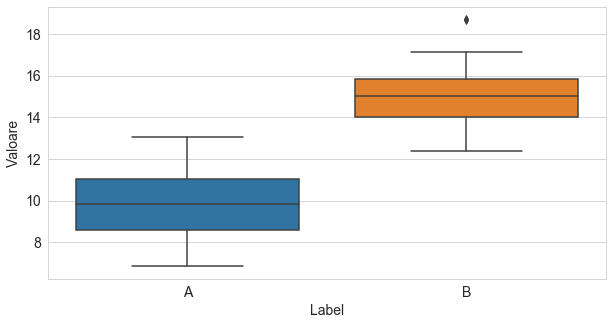

In [49]:
box_plot(df_2)

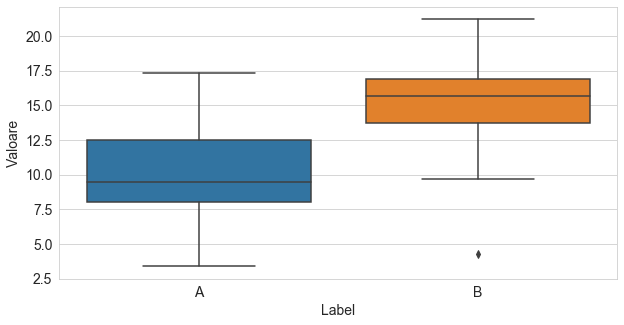

In [50]:
box_plot(df_10)

In [51]:
obs_2, permutations_2, pValue_2 = observe(df_2)

observedStat: 5.167543833222036
p-value: 0.0


In [52]:
obs_10, permutations_10, pValue_10 = observe(df_10)

observedStat: 4.932785144920336
p-value: 0.0


deviația standard:  0.6380602567793403
quantila 2.5%: -1.2220463607300323
quantila 97.5%: 1.2660895734138904


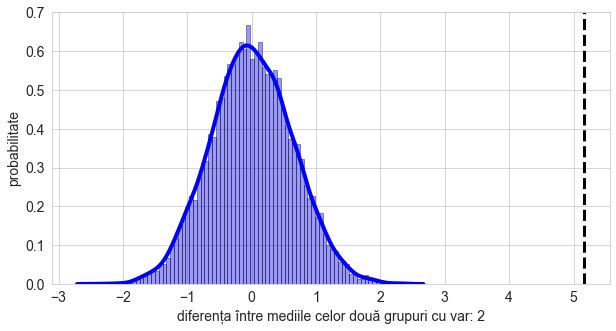

In [53]:
graph(permutations=permutations_2, var=2, observedStat=obs_2)

deviația standard:  0.8650584937380188
quantila 2.5%: -1.6825701300635407
quantila 97.5%: 1.6821897193845214


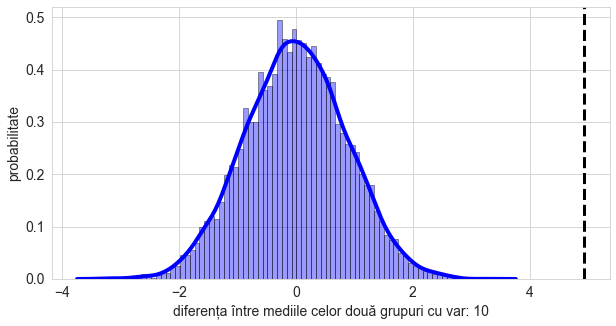

In [54]:
graph(permutations=permutations_10, var=10, observedStat=obs_10)

In [55]:
print(f'R Q9. a) Ipoteza nulă presupune că nu există diferențe semnificative între medii dacă am schimba etichetele grupurilor.')
print(f'R Q9. a) Ipoteza nulă presupune că numerele sunt extrase din aceeași distribuție.')
print()
print(f'R Q9. a) Ipoteza alternativă presupune că etichetele grupurilor sunt relevante pentru că diferențele între medii sunt mari.')
print(f'R Q9. a) Ipoteza alternativă presupune că numerele nu sunt extrase din aceeași distribuție.')
print()
print(f'R Q9. a) p-value: {pValue_2}')
print(f'R Q9. a) rezultatul testului ipotezei cu var 2: {obs_2}')
print(f'R Q9. a) p-value: {pValue_10}')
print(f'R Q9. a) rezultatul testului ipotezei cu var 10: {obs_10}')
print()
print(f'R Q9. b) Crescând dispersia grupurilor se poate observa că numerele nu sunt extrase din aceeași distrbuție.')

R Q9. a) Ipoteza nulă presupune că nu există diferențe semnificative între medii dacă am schimba etichetele grupurilor.
R Q9. a) Ipoteza nulă presupune că numerele sunt extrase din aceeași distribuție.

R Q9. a) Ipoteza alternativă presupune că etichetele grupurilor sunt relevante pentru că diferențele între medii sunt mari.
R Q9. a) Ipoteza alternativă presupune că numerele nu sunt extrase din aceeași distribuție.

R Q9. a) p-value: 0.0
R Q9. a) rezultatul testului ipotezei cu var 2: 5.167543833222036
R Q9. a) p-value: 0.0
R Q9. a) rezultatul testului ipotezei cu var 10: 4.932785144920336

R Q9. b) Crescând dispersia grupurilor se poate observa că numerele nu sunt extrase din aceeași distrbuție.
